This project creates a model that classifies handwritten 3s and 7s from the MNIST sample dataset.

In [1]:
!pip install -Uqq fastai

In [2]:
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
Path.BASE_PATH = path

In [5]:
path

Path('.')

We check what's in path:

In [6]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

Checking the train folder:

In [7]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

We can sort the training data:

In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [9]:
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [10]:
sevens

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

Taking a look at one image from the 3s folder:

In [11]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [12]:
type(im3)

PIL.PngImagePlugin.PngImageFile

We need to represent this in number format as everything is represented as numbers in computers.
To view the number that represent this image we convert it to a Numpy array or PyTorch tensor.


To convert it to a Numpy array:

In [13]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

To convert to a PyTorch Tensor:

In [14]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [15]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Creating a model that detects a 3

#### Pixel Similarity  
- Find the average pixel value for every pixel; of the threes and sevens.  
- The two group averages define the "ideal" 3 and 7.  
- Then to classify an image as a digit, we see which of these two ideal digits the image is similar to.

##### Create a baseline model

First, we need to list all the images of sevens and threes as tensors.

In [16]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

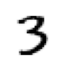

In [17]:
show_image(three_tensors[1]);

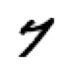

In [18]:
show_image(seven_tensors[1]);

In [19]:
type(seven_tensors)

list

We now need to get the average of all those 3s and 7s.  
First we need to change three_tensors and seven_tensors from lists, which can't easily do mathematical computations.

In [21]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

This stacks up all the 28×28 pixels images on top of each other.

In [22]:
len(stacked_threes.shape)

3

This gives us a Rank 3 tensor.

We can also get it from 'ndim' that stands for number of dimensions.

In [23]:
stacked_threes.ndim

3

In [ ]:
Getting the mean for 3 and 7:

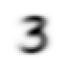

In [24]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

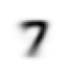

In [25]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

This shows us the ideal 3 and 7.

Now, let's grab a 3:

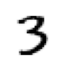

In [26]:
a_3 = stacked_threes[1]
show_image(a_3);

We can find if the a_3 is similar to the 'ideal' 3 or 7.  
The one that is more similar to, that's the answer.

This can be achieved by:  
1) Finding the absolute values (simply means removing the minus sign), the take the average. This is called the Mean Absolute Difference or L1 norm.  
2) Take the square of each difference and the take the mean then find the square root to undo the squaring. This is called Root Mean Squared Error or L2 norm.|

In [27]:
dist_3_abs = (a_3-mean3).abs().mean()
dist_3_sqr = ((a_3-mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [28]:
dist_7_abs = (a_3-mean7).abs().mean()
dist_7_sqr = ((a_3-mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

The distance in terms of absolute from mean of 3 is 0.114 and mean of 7 is 0.1586 so its close to the mean of 3 than the mean of 7. Therefore, we can guess that its a 3 based on the mean absolute differences.  
This is same for the root mean squared error.